In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import numpy as np

In [109]:
#select two parameters (column_1 and column_2) to regress against price, will also include points
#x_rank is number of top highest of each of the categories
#percentile is cut off at which highest prices are removed

#example:  RegressWines('country', 'variety', 6, 99):
#takes the top 6 countries and top 6 varities and points (score), and removes the retains the bottom 99% of prices in distribution and regresses to predict prices
#column_1 and column_2 can be any of the following ['country', 'designation', 'province', 'variety', 'price', 'winery']

def RegressWines(column_1, column_2, x_ranks, percentile, model_type):

    #import first 150k reviews, and second 130k reviews
    review1 = pd.read_csv(os.path.join('winemag-data_first150k.csv'))
    review2 = pd.read_csv(os.path.join('winemag-data-130k-v2.csv'))

    #concatenate both dataframes by common columns
    review_df = pd.concat([review1, review2], sort=False)

    #drop unnamed index columns
    review_df = review_df.drop(['Unnamed: 0'], axis=1)

    #reduce reviews to columns we want to regress against
    model_df = review_df[['country', 'designation', 'points', 'province', 'variety', 'price', 'winery']]

    #drop NaN values
    model_df = model_df.dropna()

    #print total number of starting data points
    print(f"Starting data points for analysis: {len(model_df)}")    

    #list top x ranked items from column_1 and place in list to train data set
    category_1 = pd.DataFrame(model_df[column_1].value_counts().head(x_ranks))
    category_1 = category_1.index.tolist()

    #list top x ranked items from column_2 and place in list to train data set
    category_2 = pd.DataFrame(model_df[column_2].value_counts().head(x_ranks))
    category_2 = category_2.index.tolist()


    #reduce dataframe to contain only data points in top x_rank from columns 1 and columns 2 selected
    model_df = model_df.loc[model_df[column_1].isin(category_1)]
    model_df = model_df.loc[model_df[column_2].isin(category_2)]

    #print remaining number of data points
    print(f"Filtered Data Points: {len(model_df)}") 
    print("-"*60)
    print(column_1)
    print(category_1)
    print("-"*60)
    print(column_2)
    print(category_2)
    print("-"*60)

    #max price is definded as percentile cutoff
    max_price = np.percentile(model_df['price'], percentile)
    print(f"Starting Max Price = {round(max_price,2)}")

    #remove top (100-percentile) of prices
    model_df = model_df.loc[model_df['price']<= max_price]

    #print new max price
    print(f"New Max Price = round({model_df['price'].max()},2)")

    #define X and y parameters
    X = model_df[['points', column_1, column_2]]
    y = model_df["price"].values.reshape(-1, 1)

    #mirror X into data to assign categorical values
    data = X.copy()

    # using get_dummies with a single column
    X = pd.get_dummies(data, columns=[column_1, column_2])

    #define training and testing variables
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    #scale and transform X and y values
    from sklearn.preprocessing import StandardScaler
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)

    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    
    if model_type=="Linear":
        # Generate the model and fit it to the scaled training data
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
        model.fit(X_train_scaled, y_train_scaled)
        linear_predictions = model.predict(X_test_scaled)
        MSE = mean_squared_error(y_test_scaled, linear_predictions)
        r2 = model.score(X_test_scaled, y_test_scaled)

        plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
        plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
        plt.legend()
        plt.title("Residual Plot")
        plt.show()

    ########LASSO############    

    elif model_type=="Lasso":
        # Note: Use an alpha of .01 when creating the model for this activity
        from sklearn.linear_model import Lasso

        lasso = Lasso(alpha=.05).fit(X_train_scaled, y_train_scaled)
        lasso_predictions = lasso.predict(X_test_scaled)
        MSE = mean_squared_error(y_test_scaled, lasso_predictions)
        r2 = lasso.score(X_test_scaled, y_test_scaled)

        plt.scatter(lasso.predict(X_train_scaled), lasso.predict(X_train_scaled) - y_train_scaled[:,0], c="blue", label="Training Data")
        plt.scatter(lasso.predict(X_test_scaled), lasso.predict(X_test_scaled) - y_test_scaled[:,0], c="orange", label="Testing Data")
        plt.legend()
        plt.title("Residual Plot")
        plt.show()

    elif model_type=="Ridge":
    # Note: Use an alpha of .01 when creating the model for this activity
        from sklearn.linear_model import Ridge

        ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)
        predictions = ridge.predict(X_test_scaled)

        plt.scatter(ridge.predict(X_train_scaled), ridge.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
        plt.scatter(ridge.predict(X_test_scaled), ridge.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
        plt.legend()
        plt.title("Residual Plot")
        plt.show()
          
        MSE = mean_squared_error(y_test_scaled, predictions)
        r2 = ridge.score(X_test_scaled, y_test_scaled)
        
    elif model_type=="Elastic Net":
        from sklearn.linear_model import ElasticNet

        elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)
        predictions = elasticnet.predict(X_test_scaled)
        MSE = mean_squared_error(y_test_scaled, predictions)
        r2 = elasticnet.score(X_test_scaled, y_test_scaled)

        plt.scatter(elasticnet.predict(X_train_scaled), elasticnet.predict(X_train_scaled) - y_train_scaled[:,0], c="blue", label="Training Data")
        plt.scatter(elasticnet.predict(X_test_scaled), elasticnet.predict(X_test_scaled) - y_test_scaled[:,0], c="orange", label="Testing Data")
        plt.legend()
        plt.title("Residual Plot")
        plt.show()
          
        MSE = mean_squared_error(y_test_scaled, predictions)
        r2 = elasticnet.score(X_test_scaled, y_test_scaled)

    return print(f"Model Type: {model_type}, MSE: {MSE}, R2: {r2}")
        

Starting data points for analysis: 181067
Filtered Data Points: 1294
------------------------------------------------------------
winery
['Williams Selyem', 'Testarossa', 'DFJ Vinhos', 'Concha y Toro', 'Columbia Crest', 'Wines & Winemakers']
------------------------------------------------------------
variety
['Pinot Noir', 'Chardonnay', 'Red Blend', 'Cabernet Sauvignon', 'Riesling', 'Syrah']
------------------------------------------------------------
Starting Max Price = 120.35
New Max Price = round(120.0,2)


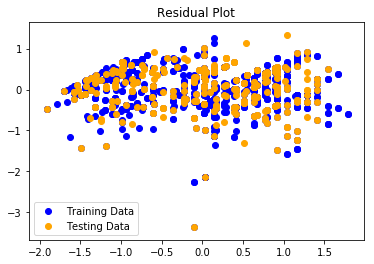

Model Type: Elastic Net, MSE: 0.2796957690179623, R2: 0.7232996686428501


In [110]:
#column_1 and column_2 can be any of the following ['country', 'designation', 'province', 'variety', 'price', 'winery']
#model_type = [Linear, Ridge, Lasso, Elastic Net]
RegressWines('winery', 'variety', 6, 99, "Elastic Net")